# Módulo 1: Análisis de datos en el ecosistema Python

### Sesión (27)

# `ALEJANDRO SÁNCHEZ MONZÓN`

**08/04/2024**

# Machine Learning Time Series Forecasting

In [1]:
# importamos las librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Modificamos los parámetros de los gráficos en matplotlib
from matplotlib.pyplot import rcParams

rcParams['figure.figsize'] = 12, 6 # el primer dígito es el ancho y el segundo el alto
rcParams["font.weight"] = "bold"
rcParams["font.size"] = 10
rcParams["axes.labelweight"] = "bold"

In [3]:
pip install skforecast==0.7.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


---

### **`Ejercicio 27`**

Vamos a analizar los datos de **`Sunspots Dataset`** que son números promediados mensuales de **manchas solares desde 1749 hasta 1983**.  


- Utilizamos el siguiente enlace para descargar los datos y crear una tabla tipo _DataFrame_ con ellos:
  - 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'  
  

- Construimos la serie temporal, del modo que las fechas tipo `'1749-05-01'` formen los índices, y número de las manchas solares los valores de la serie.


---

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Sunspots Quality dataset
df_spot = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col=False)
df_spot


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


In [6]:
# Convertir la columna en fechas tipo DatetimeIndex
df_spot['fechas'] = pd.to_datetime(df_spot['Month'], format='%Y-%m')

# Convertir la columna de fechas a los índices del DataFrame
df_spot.set_index('fechas', inplace=True)
df_spot.index.freq = 'MS'

# Remove the "year" and "month" columns
df_spot.drop(columns='Month', inplace=True)

df_spot

,Sunspots
fechas,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


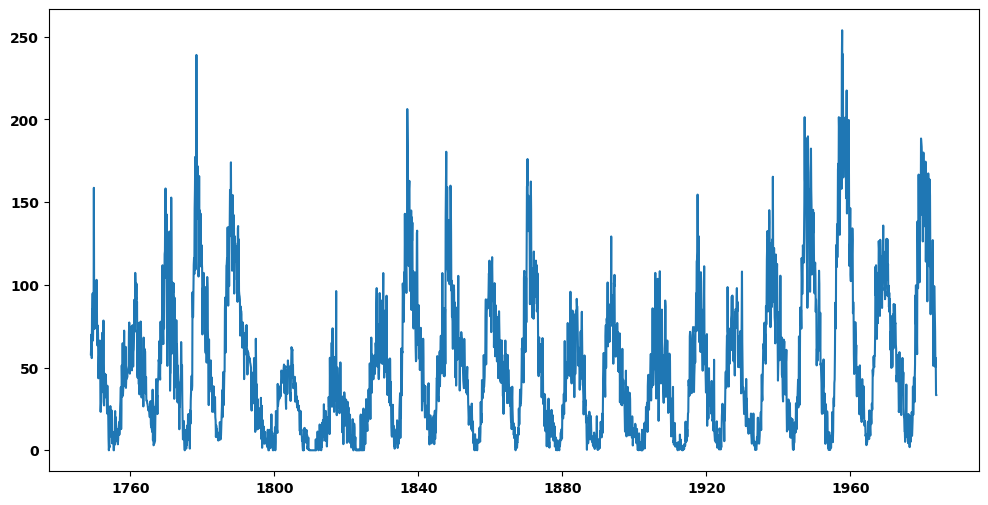

In [7]:
# Visualizar el DataFrame creado con los datos de la serie temporal
plt.plot(df_spot)
plt.show()

In [8]:
# Definir el periodo de prueba (horizonte de predicción)
horizonte = 12  # La cantidad de puntos a predecir
df_spot_test = df_spot.tail(horizonte)
df_spot_test

,Sunspots
fechas,
1983-01-01,84.3
1983-02-01,51.0
1983-03-01,66.5
1983-04-01,80.7
1983-05-01,99.2
1983-06-01,91.1
1983-07-01,82.2
1983-08-01,71.8
1983-09-01,50.3


In [9]:
# Filtrar la serie original para sacar el periodo de entrenamiento
df_spot_train = df_spot[~df_spot.index.isin(df_spot_test.index)]
df_spot_train

,Sunspots
fechas,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1982-08-01,107.6
1982-09-01,118.8
1982-10-01,94.7


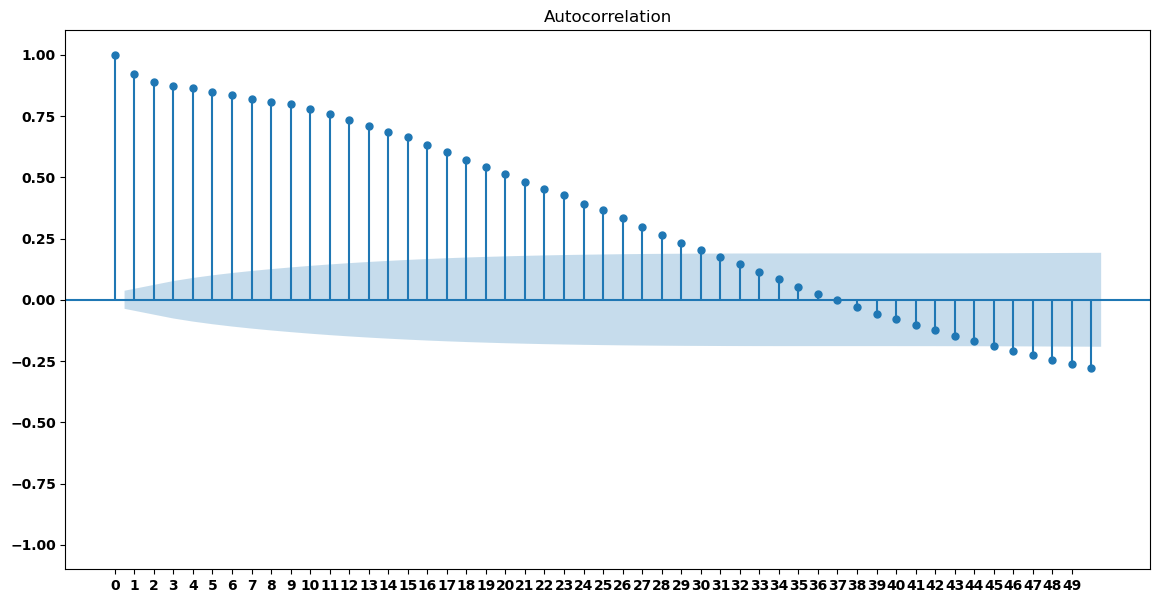

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 7
plot_acf(df_spot, lags=50)
plt.xticks(np.arange(50))
plt.ylim(-1.1,1.1)
plt.show()

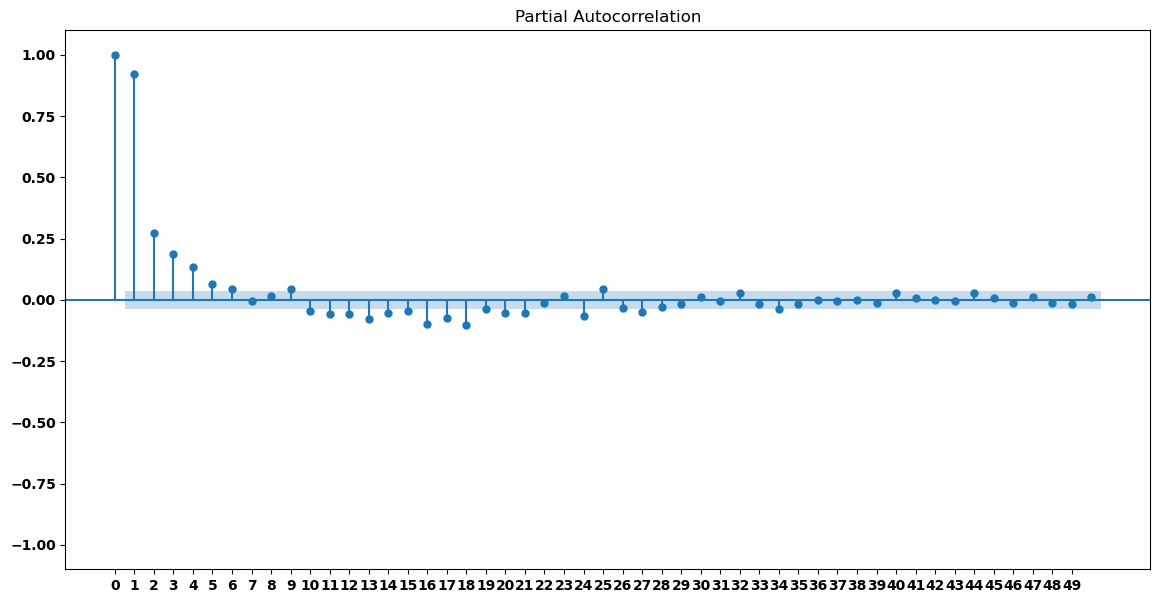

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_spot, lags=50, method='ywm')
plt.xticks(np.arange(50))
plt.ylim(-1.1,1.1)
plt.show()

Vemos que los retrasos con algo de autocorrelación parcial pueden llegar hasta el lag 34 aproximadamente.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import r2_score

El mejor valor de n_estimators podría ser = 110  que consigue un R2 = -0.8420977037531128


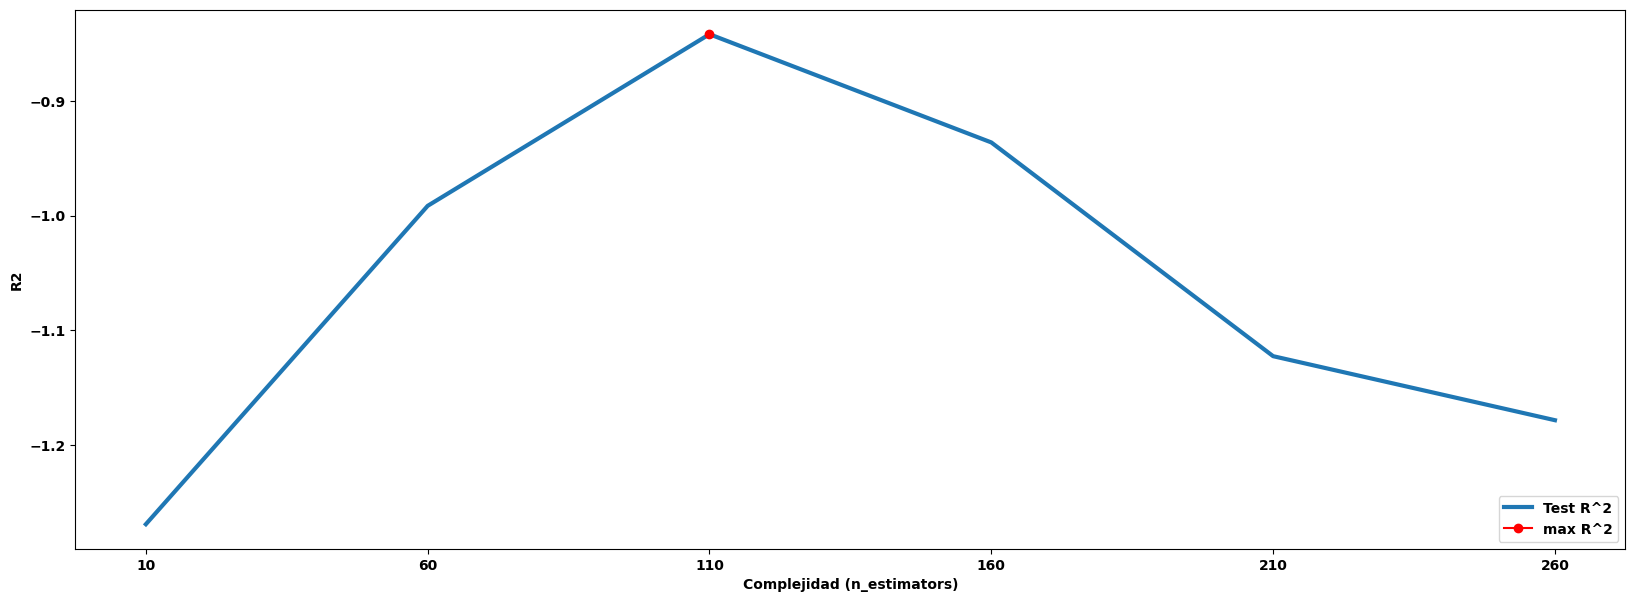

In [14]:
# Consideramos un rango para asignar el hiperparámetro
hiper_param = np.arange(10,301,50)

# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size)

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=hiper_param[i],
                                                      random_state=77),
                lags = 34
                )

    mod_bosque.fit(y=df_spot_train['Sunspots'])
    test_r2[i] = r2_score(df_spot_test, mod_bosque.predict(steps=horizonte))

print("El mejor valor de n_estimators podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (n_estimators)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()


El mejor valor de max_depth podría ser = 20  que consigue un R2 = -0.7322556095861794


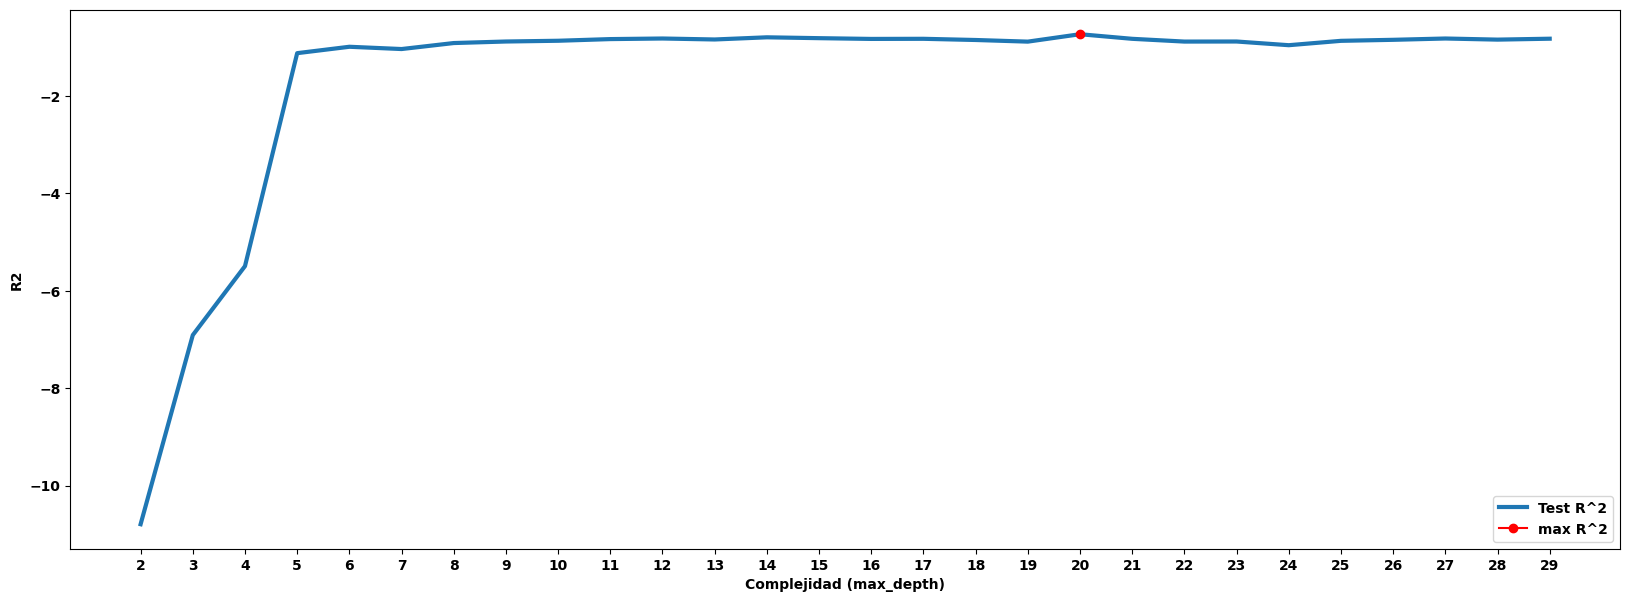

In [15]:
# Consideramos un rango para asignar el hiperparámetro
hiper_param = np.arange(2,30)

# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size)

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = RandomForestRegressor(max_depth=hiper_param[i],
                                                      n_estimators=110,
                                                      random_state=77),
                lags = 34
                )

    mod_bosque.fit(y=df_spot_train['Sunspots'])
    test_r2[i] = r2_score(df_spot_test, mod_bosque.predict(steps=horizonte).round())

print("El mejor valor de max_depth podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (max_depth)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()


In [16]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

mod_spot_rf = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=110,
                                                  max_depth=20,
                                                  random_state=77),
                lags = 34
                )

mod_spot_rf.fit(y=df_spot_train['Sunspots'])
pred_spot_rf = mod_spot_rf.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_spot_test, pred_spot_rf))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_spot_test, pred_spot_rf)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_spot_test, pred_spot_rf))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_spot_test, pred_spot_rf)))
print('R^2 coefficient of determination:', r2_score(df_spot_test, pred_spot_rf))


Mean Absolute Error (MAE): 23.366666666666664
Mean Absolute Percentage Error: 46.37821965219938
Mean Squared Error (MSE): 762.5283333333333
Root Mean Squared Error (RMSE): 27.613915574096573
R^2 coefficient of determination: -0.7322556095861794


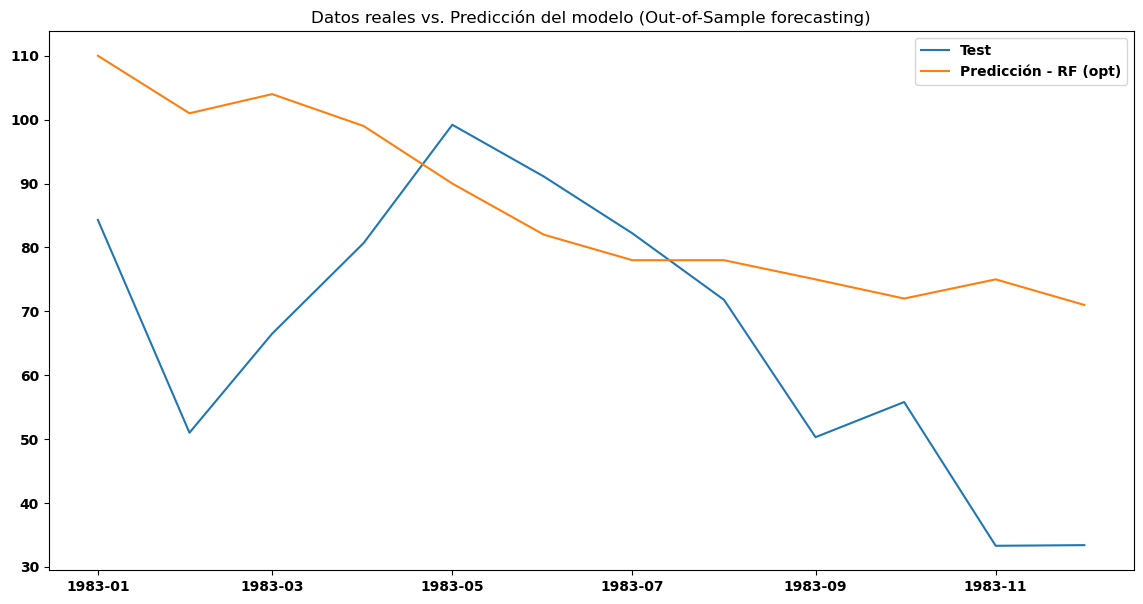

In [17]:
plt.plot(df_spot_test, label='Test')
plt.plot(pred_spot_rf, label='Predicción - RF (opt)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

---

### **`Ejercicio 27.1`**

Vamos a intentar a modelar la serie temporal con el objetivo de predecir los valores mensuales del último año. 

**`27.1.1`** Realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de retrasos, teniendo en cuenta los siguientes puntos:

- Hasta `lag_34` inclusive
- Modelo: **XGBoost**
- `random_state=77`

**`27.1.2`** Teniendo en cuenta el valor óptimo calculado en el paso anterior para los retrasos, realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de **árboles**, teniendo en cuenta los siguientes puntos:

- De 10 hasta 300 con pasos de 50
- `random_state=77`

**`27.1.3`** Teniendo en cuenta los valores óptimos calculados en los pasos anteriores, realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de la **profundidad máxima**, teniendo en cuenta los siguientes puntos:

- De 2 a 30
- `random_state=77`

**`27.1.4`** Construye un modelo con los hiperparámetros óptimos que hayas calculado y calcula las métricas de calidad del modelo y de tus predicciones:

- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

**`27.1.5`** Saca la gráfica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_" y **analiza y compara los resultados** de este modelo con el último modelo contruido en la sesión.

---

In [18]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


El mejor valor de retrasos podría ser = 13  que consigue un R2 = -0.3400042153142113


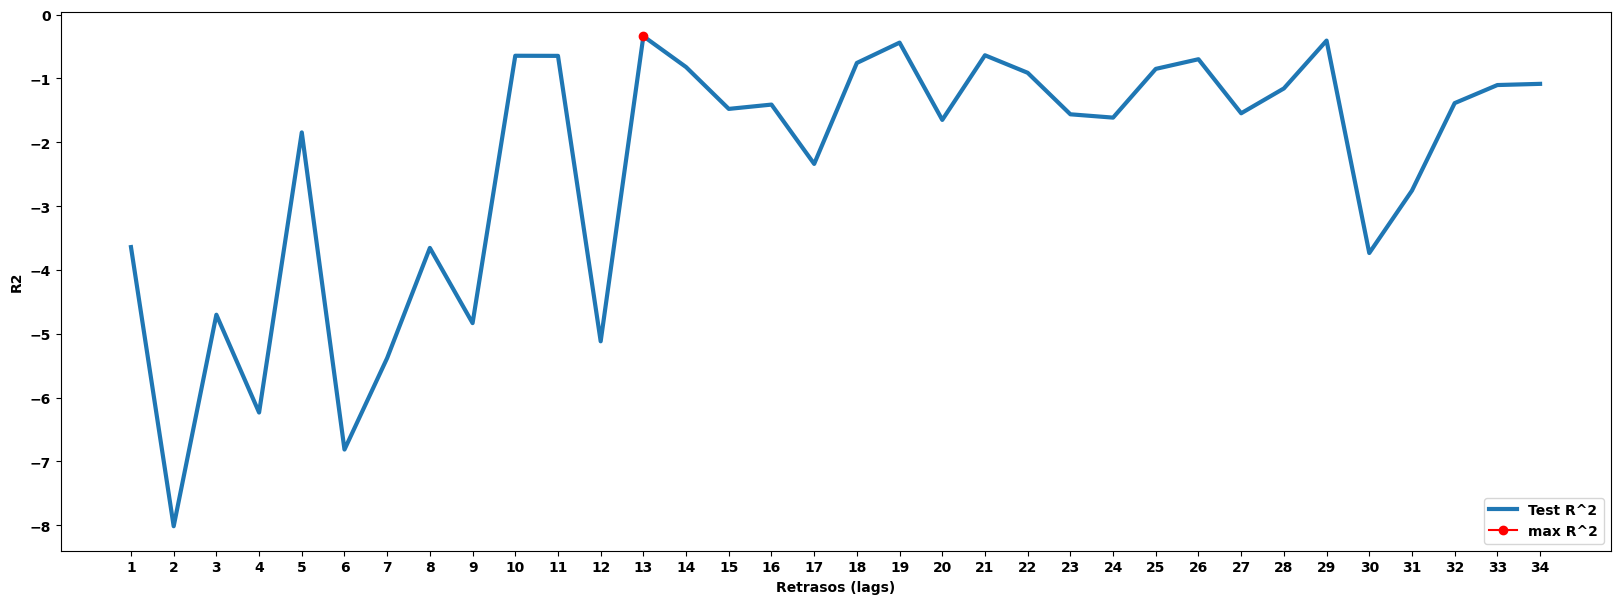

In [20]:
## Solución 27.1.1
from xgboost import XGBRegressor

hiper_param_27_1_1 = np.arange(1, 35).tolist()

test_r2_27_1_1 = np.zeros(len(hiper_param_27_1_1))

for i in range(len(hiper_param_27_1_1)):
    mod_xgb_27_1_1 = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=77, n_jobs=-1),
                    lags = hiper_param_27_1_1[i]
                )

    mod_xgb_27_1_1.fit(y=df_spot_train['Sunspots'])
    test_r2_27_1_1[i] = r2_score(df_spot_test, mod_xgb_27_1_1.predict(steps=12).round())

print("El mejor valor de retrasos podría ser =", hiper_param_27_1_1[np.argmax(test_r2_27_1_1)],
      " que consigue un R2 =", max(test_r2_27_1_1))

fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param_27_1_1, test_r2_27_1_1, linewidth=3, label='Test R^2')
plt.plot(hiper_param_27_1_1[np.argmax(test_r2_27_1_1)], max(test_r2_27_1_1),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param_27_1_1)
plt.xlabel('Retrasos (lags)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()


El mejor valor de número de arboles podría ser = 60  que consigue un R2 = -0.3283426873763957


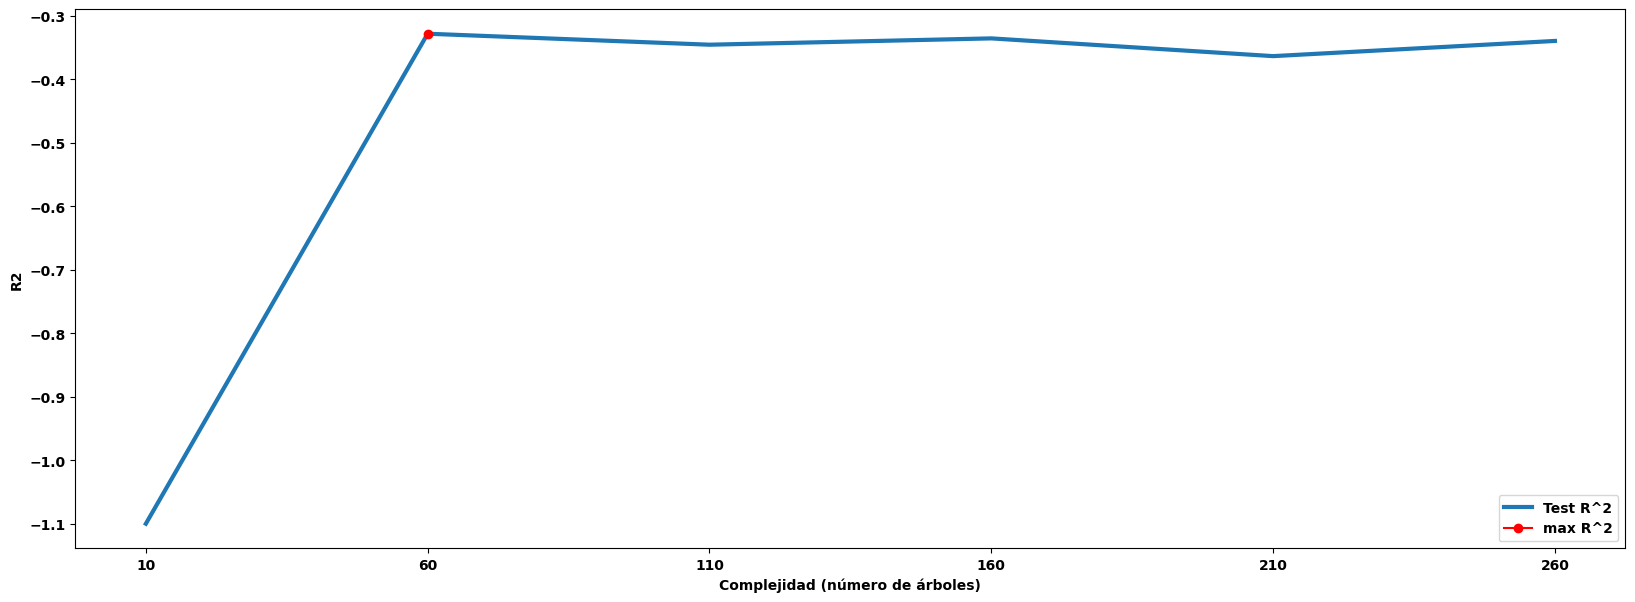

In [21]:
## Solución 27.1.2
hiper_param_27_1_2 = np.arange(10, 300, 50)

test_r2_27_1_2 = np.zeros(hiper_param_27_1_2.size)

lags_27_1 = hiper_param_27_1_1[np.argmax(test_r2_27_1_1)]

for i in range(hiper_param_27_1_2.size):
    mod_xgb_27_1_2 = ForecasterAutoreg(
                    regressor = XGBRegressor(
                        n_estimators=hiper_param_27_1_2[i],
                        random_state=77,
                        n_jobs=-1
                        ),
                    lags = lags_27_1
                )

    mod_xgb_27_1_2.fit(y=df_spot_train['Sunspots'])
    test_r2_27_1_2[i] = r2_score(df_spot_test, mod_xgb_27_1_2.predict(steps=12).round())

print("El mejor valor de número de arboles podría ser =", hiper_param_27_1_2[np.argmax(test_r2_27_1_2)],
      " que consigue un R2 =", max(test_r2_27_1_2))

fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param_27_1_2, test_r2_27_1_2, linewidth=3, label='Test R^2')
plt.plot(hiper_param_27_1_2[np.argmax(test_r2_27_1_2)], max(test_r2_27_1_2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param_27_1_2)
plt.xlabel('Complejidad (número de árboles)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()


El mejor valor de profundidad podría ser = 13  que consigue un R2 = -0.3135764669356558


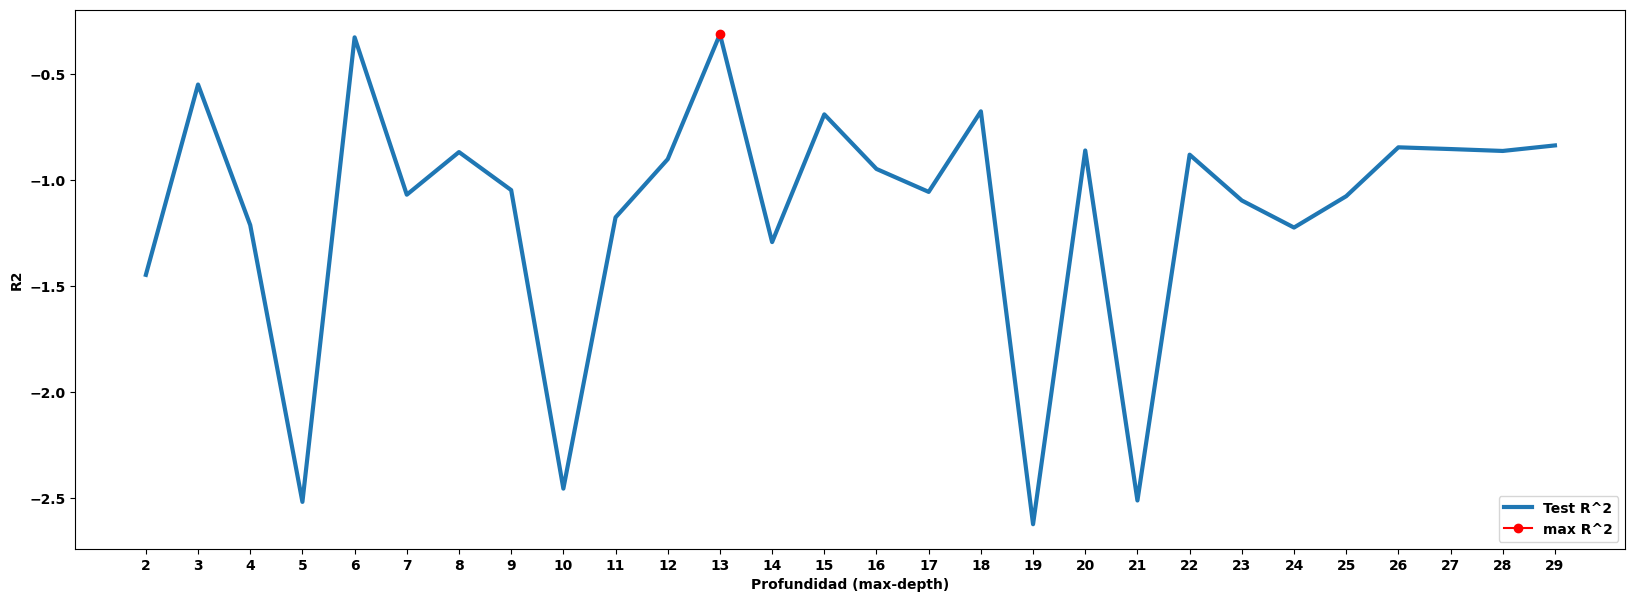

In [22]:
##Solución 27.1.3
hiper_param_27_1_3 = np.arange(2, 30)

test_r2_27_1_3 = np.zeros(hiper_param_27_1_3.size)

n_estimators_27_1 = hiper_param_27_1_2[np.argmax(test_r2_27_1_2)]

for i in range(hiper_param_27_1_3.size):
    mod_xgb_27_1_3 = ForecasterAutoreg(
                    regressor = XGBRegressor(
                        random_state=77,
                        n_jobs=-1,
                        n_estimators=n_estimators_27_1,
                        max_depth=hiper_param_27_1_3[i]),
                    lags = lags_27_1
                )

    mod_xgb_27_1_3.fit(y=df_spot_train['Sunspots'])
    test_r2_27_1_3[i] = r2_score(df_spot_test, mod_xgb_27_1_3.predict(steps=12).round())

print("El mejor valor de profundidad podría ser =", hiper_param_27_1_3[np.argmax(test_r2_27_1_3)],
      " que consigue un R2 =", max(test_r2_27_1_3))

fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param_27_1_3, test_r2_27_1_3, linewidth=3, label='Test R^2')
plt.plot(hiper_param_27_1_3[np.argmax(test_r2_27_1_3)], max(test_r2_27_1_3),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param_27_1_3)
plt.xlabel('Profundidad (max-depth)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()


In [26]:
## Solución 27.1.4
max_depth_27_1 = hiper_param_27_1_3[np.argmax(test_r2_27_1_3)]

modelo_27_1_4 = ForecasterAutoreg(
    regressor = XGBRegressor(max_depth=max_depth_27_1, n_estimators=n_estimators_27_1, random_state=77, n_jobs=-1),
    lags = lags_27_1
)

modelo_27_1_4.fit(y=df_spot_train['Sunspots'])

y_pred_27_1_4 = modelo_27_1_4.predict(steps=12)

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

print('Mean Absolute Error (MAE):', mean_absolute_error(df_spot_test, y_pred_27_1_4))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_spot_test, y_pred_27_1_4)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_spot_test, y_pred_27_1_4))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_spot_test, y_pred_27_1_4)))
print('R^2 coefficient of determination:', r2_score(df_spot_test, y_pred_27_1_4))

Mean Absolute Error (MAE): 20.30670897165934
Mean Absolute Percentage Error: 39.88299611234864
Mean Squared Error (MSE): 575.4738067623801
Root Mean Squared Error (RMSE): 23.989035136127924
R^2 coefficient of determination: -0.30731893669618304


#### Explicación 27.1.4
> Podemos observar que los valores de las métricas no son buenos, teniendo un R2 de -0.3. Por otro lado, podemos observar también un porcentaje medio de error de aproximadamente 39.9% y un MSE de 575 (bastante alto).
>
> A pesar de todo ello, las métricas comparadas con el primer modelo que hemos usado para este mismo dataset, que tenía en torno a un R2 de -0.73, podemos ver una mejoría.

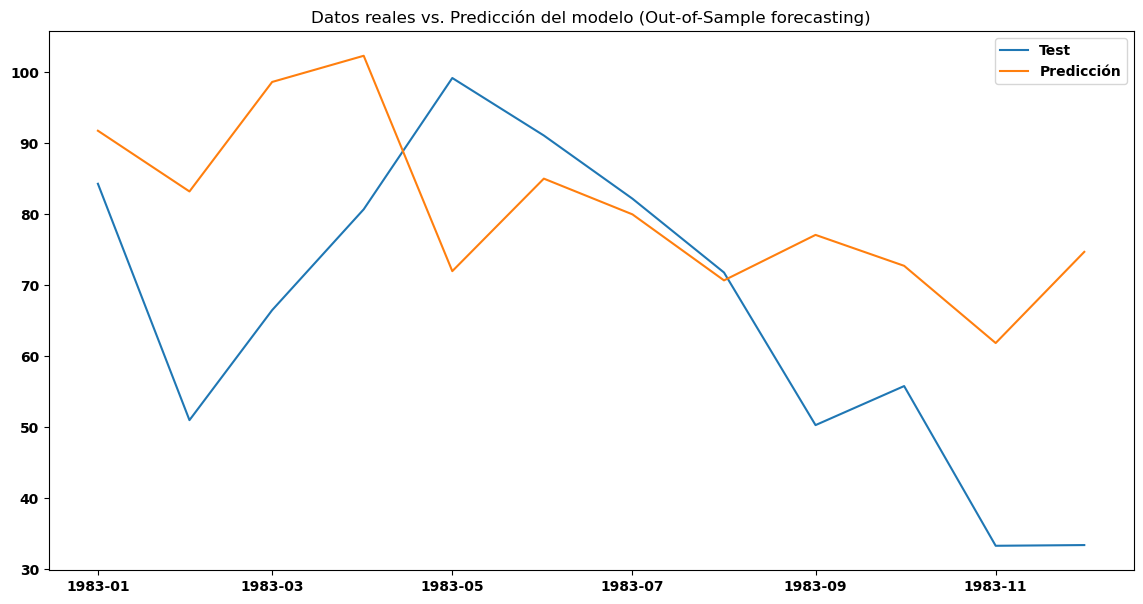

In [28]:
## Solución 27.1.5
plt.plot(df_spot_test, label='Test')
plt.plot(y_pred_27_1_4, label='Predicción')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

#### Explicación 27.1.5
> Podemos observar que la predicción no es para nada buena, no se acerca mucho a la gráfica de test y tienen una forma muy distinta entre ellas. Este resultado se entiende, ya que al final hemos ido acumulando hiperparámetros que, aun siendo los más óptimos en base a nuestro análisis, seguían teniendo valores de R2 muy bajos (por debajo de 0). Si como resultado obtenemos un modelo con un R2 también negativo, es normal que las gráficas de test y la de predicción sean muy diferentes entre ellas.
>
> A pesar de esto podemos vr un intento en las predicciones de seguir una tendencia a la que se le podría intentar buscar la similitud con la gráfica de test. Pero, sin duda, de una forma muy superficial.